<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:19] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


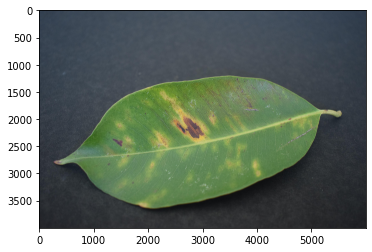

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

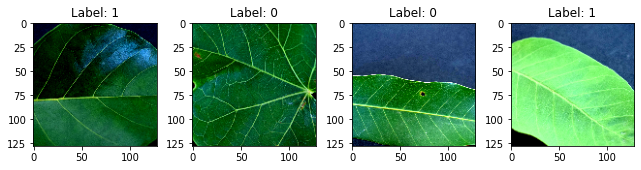

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2550996698046373 samples/sec                   batch loss = 0.9473882913589478 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2268180120041905 samples/sec                   batch loss = 0.6313734650611877 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2660585005523513 samples/sec                   batch loss = 0.7882646918296814 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2634424760774008 samples/sec                   batch loss = 1.6994396448135376 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2588854883669207 samples/sec                   batch loss = 0.8274392485618591 | accuracy = 0.55


Epoch[1] Batch[30] Speed: 1.2636385074811454 samples/sec                   batch loss = 1.17914879322052 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2655293317363998 samples/sec                   batch loss = 0.5675210356712341 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.2617538942998217 samples/sec                   batch loss = 0.3905397057533264 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2659452951462484 samples/sec                   batch loss = 0.9243311285972595 | accuracy = 0.5388888888888889


Epoch[1] Batch[50] Speed: 1.2622267282717468 samples/sec                   batch loss = 0.5938303470611572 | accuracy = 0.535


Epoch[1] Batch[55] Speed: 1.2629390683593762 samples/sec                   batch loss = 0.818244218826294 | accuracy = 0.5409090909090909


Epoch[1] Batch[60] Speed: 1.2610863980011695 samples/sec                   batch loss = 0.5172003507614136 | accuracy = 0.55


Epoch[1] Batch[65] Speed: 1.2616052161218392 samples/sec                   batch loss = 0.9450705051422119 | accuracy = 0.573076923076923


Epoch[1] Batch[70] Speed: 1.2615793172535237 samples/sec                   batch loss = 0.7767411470413208 | accuracy = 0.5785714285714286


Epoch[1] Batch[75] Speed: 1.2649519626784789 samples/sec                   batch loss = 0.3760322332382202 | accuracy = 0.5833333333333334


Epoch[1] Batch[80] Speed: 1.2676530714633714 samples/sec                   batch loss = 0.5746943950653076 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2519339731792438 samples/sec                   batch loss = 0.719534158706665 | accuracy = 0.6029411764705882


Epoch[1] Batch[90] Speed: 1.2552657897751287 samples/sec                   batch loss = 0.4860280752182007 | accuracy = 0.6083333333333333


Epoch[1] Batch[95] Speed: 1.2482759698251007 samples/sec                   batch loss = 0.8039461970329285 | accuracy = 0.6105263157894737


Epoch[1] Batch[100] Speed: 1.2563204415313807 samples/sec                   batch loss = 0.43544667959213257 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.263191150050826 samples/sec                   batch loss = 0.4667855501174927 | accuracy = 0.6023809523809524


Epoch[1] Batch[110] Speed: 1.2605534206825926 samples/sec                   batch loss = 0.5080298781394958 | accuracy = 0.6068181818181818


Epoch[1] Batch[115] Speed: 1.2601782854780463 samples/sec                   batch loss = 0.5807735323905945 | accuracy = 0.6021739130434782


Epoch[1] Batch[120] Speed: 1.2588015181354522 samples/sec                   batch loss = 0.48405948281288147 | accuracy = 0.60625


Epoch[1] Batch[125] Speed: 1.2608727739610466 samples/sec                   batch loss = 0.535152792930603 | accuracy = 0.608


Epoch[1] Batch[130] Speed: 1.2563041665150314 samples/sec                   batch loss = 0.6779223680496216 | accuracy = 0.6076923076923076


Epoch[1] Batch[135] Speed: 1.2547349986983143 samples/sec                   batch loss = 0.35422515869140625 | accuracy = 0.6092592592592593


Epoch[1] Batch[140] Speed: 1.2545768058154423 samples/sec                   batch loss = 0.5555506944656372 | accuracy = 0.6053571428571428


Epoch[1] Batch[145] Speed: 1.2565119163009222 samples/sec                   batch loss = 0.4633643925189972 | accuracy = 0.6155172413793103


Epoch[1] Batch[150] Speed: 1.261231919875179 samples/sec                   batch loss = 0.4636228084564209 | accuracy = 0.6166666666666667


Epoch[1] Batch[155] Speed: 1.2604071084332824 samples/sec                   batch loss = 0.4147835969924927 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2655362049428671 samples/sec                   batch loss = 0.6280800104141235 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.2567303722958678 samples/sec                   batch loss = 0.2578446865081787 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2577160150234294 samples/sec                   batch loss = 0.6386071443557739 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.2627680600340372 samples/sec                   batch loss = 0.433901309967041 | accuracy = 0.6357142857142857


Epoch[1] Batch[180] Speed: 1.2558164880286906 samples/sec                   batch loss = 0.959384024143219 | accuracy = 0.6333333333333333


Epoch[1] Batch[185] Speed: 1.2573358762012623 samples/sec                   batch loss = 0.5951306819915771 | accuracy = 0.6364864864864865


Epoch[1] Batch[190] Speed: 1.249784044984197 samples/sec                   batch loss = 0.9331275820732117 | accuracy = 0.6355263157894737


Epoch[1] Batch[195] Speed: 1.2351851472830915 samples/sec                   batch loss = 0.38782596588134766 | accuracy = 0.6358974358974359


Epoch[1] Batch[200] Speed: 1.2611140777516392 samples/sec                   batch loss = 1.2165488004684448 | accuracy = 0.635


Epoch[1] Batch[205] Speed: 1.2612846383643461 samples/sec                   batch loss = 0.37318313121795654 | accuracy = 0.6353658536585366


Epoch[1] Batch[210] Speed: 1.2688412022230944 samples/sec                   batch loss = 0.4822603464126587 | accuracy = 0.6357142857142857


Epoch[1] Batch[215] Speed: 1.2589410338881672 samples/sec                   batch loss = 0.981855034828186 | accuracy = 0.6372093023255814


Epoch[1] Batch[220] Speed: 1.2612828367605122 samples/sec                   batch loss = 0.4286586046218872 | accuracy = 0.6397727272727273


Epoch[1] Batch[225] Speed: 1.2683289774853905 samples/sec                   batch loss = 0.4634110927581787 | accuracy = 0.64


Epoch[1] Batch[230] Speed: 1.2617705006111728 samples/sec                   batch loss = 0.2779461443424225 | accuracy = 0.6456521739130435


Epoch[1] Batch[235] Speed: 1.2568247996649908 samples/sec                   batch loss = 0.5140541195869446 | accuracy = 0.6436170212765957


Epoch[1] Batch[240] Speed: 1.2524321034444688 samples/sec                   batch loss = 0.42217719554901123 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.253406143560932 samples/sec                   batch loss = 0.14756247401237488 | accuracy = 0.6520408163265307


Epoch[1] Batch[250] Speed: 1.258822958288155 samples/sec                   batch loss = 0.9535353183746338 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.2610207108541616 samples/sec                   batch loss = 0.4133184850215912 | accuracy = 0.6549019607843137


Epoch[1] Batch[260] Speed: 1.256748447025143 samples/sec                   batch loss = 0.802345871925354 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.2622321411912272 samples/sec                   batch loss = 0.7797231674194336 | accuracy = 0.6547169811320754


Epoch[1] Batch[270] Speed: 1.2611180591855675 samples/sec                   batch loss = 0.32880881428718567 | accuracy = 0.6574074074074074


Epoch[1] Batch[275] Speed: 1.257178816753466 samples/sec                   batch loss = 0.33597052097320557 | accuracy = 0.66


Epoch[1] Batch[280] Speed: 1.2672641270145328 samples/sec                   batch loss = 0.8039945960044861 | accuracy = 0.6607142857142857


Epoch[1] Batch[285] Speed: 1.2654141211820749 samples/sec                   batch loss = 0.8276101350784302 | accuracy = 0.6622807017543859


Epoch[1] Batch[290] Speed: 1.2633341139493572 samples/sec                   batch loss = 0.5064412355422974 | accuracy = 0.6629310344827586


Epoch[1] Batch[295] Speed: 1.2598900319477926 samples/sec                   batch loss = 0.3310297429561615 | accuracy = 0.661864406779661


Epoch[1] Batch[300] Speed: 1.2623897059791747 samples/sec                   batch loss = 0.27247071266174316 | accuracy = 0.6616666666666666


Epoch[1] Batch[305] Speed: 1.2659873268580693 samples/sec                   batch loss = 0.42984673380851746 | accuracy = 0.6622950819672131


Epoch[1] Batch[310] Speed: 1.2554858795763806 samples/sec                   batch loss = 0.6214755177497864 | accuracy = 0.6645161290322581


Epoch[1] Batch[315] Speed: 1.2554714112104215 samples/sec                   batch loss = 0.6710898280143738 | accuracy = 0.6626984126984127


Epoch[1] Batch[320] Speed: 1.2544591722051854 samples/sec                   batch loss = 1.641960859298706 | accuracy = 0.6640625


Epoch[1] Batch[325] Speed: 1.2624476510852418 samples/sec                   batch loss = 0.7312578558921814 | accuracy = 0.6661538461538462


Epoch[1] Batch[330] Speed: 1.2620153758236712 samples/sec                   batch loss = 0.7360330820083618 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2668504533894969 samples/sec                   batch loss = 0.8891018033027649 | accuracy = 0.6701492537313433


Epoch[1] Batch[340] Speed: 1.2568618024935692 samples/sec                   batch loss = 0.6050097942352295 | accuracy = 0.6691176470588235


Epoch[1] Batch[345] Speed: 1.2546950244881876 samples/sec                   batch loss = 0.4393591582775116 | accuracy = 0.6695652173913044


Epoch[1] Batch[350] Speed: 1.2522630872571388 samples/sec                   batch loss = 0.5699593424797058 | accuracy = 0.6707142857142857


Epoch[1] Batch[355] Speed: 1.253745776032638 samples/sec                   batch loss = 0.7789677381515503 | accuracy = 0.6690140845070423


Epoch[1] Batch[360] Speed: 1.256996744752254 samples/sec                   batch loss = 0.6762086153030396 | accuracy = 0.6694444444444444


Epoch[1] Batch[365] Speed: 1.2563725620511776 samples/sec                   batch loss = 0.431318074464798 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2546786977265383 samples/sec                   batch loss = 0.5813725590705872 | accuracy = 0.6716216216216216


Epoch[1] Batch[375] Speed: 1.2593752702326162 samples/sec                   batch loss = 0.6675957441329956 | accuracy = 0.672


Epoch[1] Batch[380] Speed: 1.2532647623492648 samples/sec                   batch loss = 0.9061601161956787 | accuracy = 0.6710526315789473


Epoch[1] Batch[385] Speed: 1.2587288915037982 samples/sec                   batch loss = 1.0259851217269897 | accuracy = 0.6707792207792208


Epoch[1] Batch[390] Speed: 1.2598674201293238 samples/sec                   batch loss = 0.22422409057617188 | accuracy = 0.6730769230769231


Epoch[1] Batch[395] Speed: 1.2647106181556345 samples/sec                   batch loss = 0.575133740901947 | accuracy = 0.6715189873417722


Epoch[1] Batch[400] Speed: 1.2546614331074841 samples/sec                   batch loss = 0.8195058107376099 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.2538407861675571 samples/sec                   batch loss = 0.43834641575813293 | accuracy = 0.6728395061728395


Epoch[1] Batch[410] Speed: 1.2645525688168682 samples/sec                   batch loss = 0.425850510597229 | accuracy = 0.6731707317073171


Epoch[1] Batch[415] Speed: 1.2588216359668556 samples/sec                   batch loss = 0.6706125140190125 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2630415624685223 samples/sec                   batch loss = 0.8040146231651306 | accuracy = 0.6738095238095239


Epoch[1] Batch[425] Speed: 1.2592182679693358 samples/sec                   batch loss = 0.5200144052505493 | accuracy = 0.6735294117647059


Epoch[1] Batch[430] Speed: 1.2584259144941465 samples/sec                   batch loss = 0.8508385419845581 | accuracy = 0.675


Epoch[1] Batch[435] Speed: 1.263898485631504 samples/sec                   batch loss = 0.8957927227020264 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.2708660381880594 samples/sec                   batch loss = 0.7344861626625061 | accuracy = 0.6727272727272727


Epoch[1] Batch[445] Speed: 1.2716306693025168 samples/sec                   batch loss = 0.7708731293678284 | accuracy = 0.6741573033707865


Epoch[1] Batch[450] Speed: 1.2633333529114725 samples/sec                   batch loss = 0.13751055300235748 | accuracy = 0.6755555555555556


Epoch[1] Batch[455] Speed: 1.2671961676287777 samples/sec                   batch loss = 0.5775614976882935 | accuracy = 0.6780219780219781


Epoch[1] Batch[460] Speed: 1.2551618305241372 samples/sec                   batch loss = 0.6000707745552063 | accuracy = 0.6771739130434783


Epoch[1] Batch[465] Speed: 1.2602897990706112 samples/sec                   batch loss = 0.34536436200141907 | accuracy = 0.678494623655914


Epoch[1] Batch[470] Speed: 1.2678000170780899 samples/sec                   batch loss = 0.49617260694503784 | accuracy = 0.6787234042553192


Epoch[1] Batch[475] Speed: 1.2530031508026676 samples/sec                   batch loss = 0.6250383853912354 | accuracy = 0.6810526315789474


Epoch[1] Batch[480] Speed: 1.2568076642331392 samples/sec                   batch loss = 0.7546728849411011 | accuracy = 0.68125


Epoch[1] Batch[485] Speed: 1.2575105060400877 samples/sec                   batch loss = 0.6371108889579773 | accuracy = 0.6798969072164949


Epoch[1] Batch[490] Speed: 1.2545207066531363 samples/sec                   batch loss = 0.2457883656024933 | accuracy = 0.6806122448979591


Epoch[1] Batch[495] Speed: 1.2586186925838103 samples/sec                   batch loss = 0.7295423150062561 | accuracy = 0.6803030303030303


Epoch[1] Batch[500] Speed: 1.267127449915614 samples/sec                   batch loss = 0.40484628081321716 | accuracy = 0.681


Epoch[1] Batch[505] Speed: 1.2626486003197033 samples/sec                   batch loss = 0.7375140190124512 | accuracy = 0.6792079207920793


Epoch[1] Batch[510] Speed: 1.2628293667538348 samples/sec                   batch loss = 0.25852450728416443 | accuracy = 0.6808823529411765


Epoch[1] Batch[515] Speed: 1.255070938984753 samples/sec                   batch loss = 0.3750045895576477 | accuracy = 0.6810679611650485


Epoch[1] Batch[520] Speed: 1.2559809173011933 samples/sec                   batch loss = 0.6002326607704163 | accuracy = 0.68125


Epoch[1] Batch[525] Speed: 1.264318141363975 samples/sec                   batch loss = 0.41687020659446716 | accuracy = 0.6819047619047619


Epoch[1] Batch[530] Speed: 1.2531617894922948 samples/sec                   batch loss = 0.5923760533332825 | accuracy = 0.6816037735849056


Epoch[1] Batch[535] Speed: 1.2546089853584224 samples/sec                   batch loss = 0.565913736820221 | accuracy = 0.680841121495327


Epoch[1] Batch[540] Speed: 1.257334085860491 samples/sec                   batch loss = 0.37335118651390076 | accuracy = 0.6819444444444445


Epoch[1] Batch[545] Speed: 1.246120805389067 samples/sec                   batch loss = 0.358794242143631 | accuracy = 0.6830275229357798


Epoch[1] Batch[550] Speed: 1.2567701938728653 samples/sec                   batch loss = 0.4532493054866791 | accuracy = 0.6840909090909091


Epoch[1] Batch[555] Speed: 1.268007178202257 samples/sec                   batch loss = 0.7384044528007507 | accuracy = 0.6824324324324325


Epoch[1] Batch[560] Speed: 1.2552047456707516 samples/sec                   batch loss = 0.6554880738258362 | accuracy = 0.6808035714285714


Epoch[1] Batch[565] Speed: 1.2625192823877704 samples/sec                   batch loss = 0.5553639531135559 | accuracy = 0.6809734513274336


Epoch[1] Batch[570] Speed: 1.2543928605875092 samples/sec                   batch loss = 0.5946731567382812 | accuracy = 0.6820175438596491


Epoch[1] Batch[575] Speed: 1.25682724762197 samples/sec                   batch loss = 1.142582654953003 | accuracy = 0.6817391304347826


Epoch[1] Batch[580] Speed: 1.2521138337952793 samples/sec                   batch loss = 0.5049266815185547 | accuracy = 0.6836206896551724


Epoch[1] Batch[585] Speed: 1.260994930755907 samples/sec                   batch loss = 0.2769450843334198 | accuracy = 0.6837606837606838


Epoch[1] Batch[590] Speed: 1.2556739986845418 samples/sec                   batch loss = 0.47659561038017273 | accuracy = 0.6830508474576271


Epoch[1] Batch[595] Speed: 1.2545094499005385 samples/sec                   batch loss = 1.066011905670166 | accuracy = 0.6840336134453782


Epoch[1] Batch[600] Speed: 1.2594285899595925 samples/sec                   batch loss = 0.3492344319820404 | accuracy = 0.6841666666666667


Epoch[1] Batch[605] Speed: 1.2625793297420862 samples/sec                   batch loss = 0.463967889547348 | accuracy = 0.6855371900826446


Epoch[1] Batch[610] Speed: 1.2600096326372314 samples/sec                   batch loss = 0.5226079821586609 | accuracy = 0.6856557377049181


Epoch[1] Batch[615] Speed: 1.2568080408310154 samples/sec                   batch loss = 0.2239588052034378 | accuracy = 0.6865853658536586


Epoch[1] Batch[620] Speed: 1.2528085340126007 samples/sec                   batch loss = 0.42582374811172485 | accuracy = 0.6866935483870967


Epoch[1] Batch[625] Speed: 1.251967885799194 samples/sec                   batch loss = 0.6324459910392761 | accuracy = 0.6868


Epoch[1] Batch[630] Speed: 1.2470806001222163 samples/sec                   batch loss = 0.24879556894302368 | accuracy = 0.6876984126984127


Epoch[1] Batch[635] Speed: 1.2547366878055328 samples/sec                   batch loss = 0.8637318015098572 | accuracy = 0.6897637795275591


Epoch[1] Batch[640] Speed: 1.260845673334175 samples/sec                   batch loss = 0.58250492811203 | accuracy = 0.689453125


Epoch[1] Batch[645] Speed: 1.2555425348940465 samples/sec                   batch loss = 0.683525025844574 | accuracy = 0.6887596899224806


Epoch[1] Batch[650] Speed: 1.2635350600293809 samples/sec                   batch loss = 0.31638458371162415 | accuracy = 0.688076923076923


Epoch[1] Batch[655] Speed: 1.254523239450311 samples/sec                   batch loss = 0.41826143860816956 | accuracy = 0.6881679389312977


Epoch[1] Batch[660] Speed: 1.251888759210427 samples/sec                   batch loss = 0.45272526144981384 | accuracy = 0.6897727272727273


Epoch[1] Batch[665] Speed: 1.261912288860693 samples/sec                   batch loss = 0.5104808807373047 | accuracy = 0.6894736842105263


Epoch[1] Batch[670] Speed: 1.2593848182915839 samples/sec                   batch loss = 0.16065728664398193 | accuracy = 0.6895522388059702


Epoch[1] Batch[675] Speed: 1.264375406063362 samples/sec                   batch loss = 0.3024318814277649 | accuracy = 0.6903703703703704


Epoch[1] Batch[680] Speed: 1.263039946013021 samples/sec                   batch loss = 0.28536272048950195 | accuracy = 0.6915441176470588


Epoch[1] Batch[685] Speed: 1.2536484383733282 samples/sec                   batch loss = 0.2811807096004486 | accuracy = 0.6927007299270073


Epoch[1] Batch[690] Speed: 1.254630845872937 samples/sec                   batch loss = 0.19851164519786835 | accuracy = 0.6942028985507246


Epoch[1] Batch[695] Speed: 1.253330486600772 samples/sec                   batch loss = 0.790239691734314 | accuracy = 0.693884892086331


Epoch[1] Batch[700] Speed: 1.25513187617618 samples/sec                   batch loss = 0.42610397934913635 | accuracy = 0.6946428571428571


Epoch[1] Batch[705] Speed: 1.2611433703177264 samples/sec                   batch loss = 0.6887851357460022 | accuracy = 0.6943262411347517


Epoch[1] Batch[710] Speed: 1.2644183818155208 samples/sec                   batch loss = 0.4203234612941742 | accuracy = 0.6957746478873239


Epoch[1] Batch[715] Speed: 1.2589495361862102 samples/sec                   batch loss = 0.32740482687950134 | accuracy = 0.6968531468531468


Epoch[1] Batch[720] Speed: 1.2699356206867631 samples/sec                   batch loss = 0.8321101069450378 | accuracy = 0.6961805555555556


Epoch[1] Batch[725] Speed: 1.260778021608722 samples/sec                   batch loss = 0.46883639693260193 | accuracy = 0.696551724137931


Epoch[1] Batch[730] Speed: 1.2694523840420457 samples/sec                   batch loss = 0.308870404958725 | accuracy = 0.6965753424657535


Epoch[1] Batch[735] Speed: 1.2657747132597341 samples/sec                   batch loss = 0.5680258870124817 | accuracy = 0.6972789115646258


Epoch[1] Batch[740] Speed: 1.260726103359724 samples/sec                   batch loss = 0.3988659977912903 | accuracy = 0.6972972972972973


Epoch[1] Batch[745] Speed: 1.2546268114717345 samples/sec                   batch loss = 0.46295374631881714 | accuracy = 0.6976510067114094


Epoch[1] Batch[750] Speed: 1.2563452782072169 samples/sec                   batch loss = 0.4763578772544861 | accuracy = 0.698


Epoch[1] Batch[755] Speed: 1.255352576537398 samples/sec                   batch loss = 0.6714047193527222 | accuracy = 0.6980132450331126


Epoch[1] Batch[760] Speed: 1.2600417129497155 samples/sec                   batch loss = 0.6018306016921997 | accuracy = 0.6970394736842105


Epoch[1] Batch[765] Speed: 1.2575326563017188 samples/sec                   batch loss = 0.5548865795135498 | accuracy = 0.696078431372549


Epoch[1] Batch[770] Speed: 1.2569943903123746 samples/sec                   batch loss = 0.2868345379829407 | accuracy = 0.6977272727272728


Epoch[1] Batch[775] Speed: 1.258254521880687 samples/sec                   batch loss = 0.593379020690918 | accuracy = 0.6983870967741935


Epoch[1] Batch[780] Speed: 1.25488422071287 samples/sec                   batch loss = 0.3341122269630432 | accuracy = 0.6987179487179487


Epoch[1] Batch[785] Speed: 1.2598471742525605 samples/sec                   batch loss = 0.5161956548690796 | accuracy = 0.6971337579617835


[Epoch 1] training: accuracy=0.6976522842639594
[Epoch 1] time cost: 653.2469761371613
[Epoch 1] validation: validation accuracy=0.71


Epoch[2] Batch[5] Speed: 1.262166524542793 samples/sec                   batch loss = 0.3137374222278595 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2701689627758297 samples/sec                   batch loss = 0.2711682915687561 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.263906198077926 samples/sec                   batch loss = 0.31552714109420776 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2720067720201538 samples/sec                   batch loss = 0.584527313709259 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2677774078430561 samples/sec                   batch loss = 0.4184516668319702 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2712634583634184 samples/sec                   batch loss = 0.7824058532714844 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2616786494639796 samples/sec                   batch loss = 0.32477059960365295 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2640857056705084 samples/sec                   batch loss = 0.7895086407661438 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.259703863405019 samples/sec                   batch loss = 0.42311516404151917 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2596761509441556 samples/sec                   batch loss = 0.5126034021377563 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.262360070538361 samples/sec                   batch loss = 0.2903759777545929 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2610627953381641 samples/sec                   batch loss = 0.3135676383972168 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.258540328057939 samples/sec                   batch loss = 1.2747735977172852 | accuracy = 0.7730769230769231


Epoch[2] Batch[70] Speed: 1.2619625962321532 samples/sec                   batch loss = 0.4979369044303894 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2600089702291133 samples/sec                   batch loss = 0.6630370616912842 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2617339673031835 samples/sec                   batch loss = 0.4517400860786438 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2625530108156588 samples/sec                   batch loss = 0.5240510106086731 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2651334846818791 samples/sec                   batch loss = 0.5433449745178223 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2642113436961109 samples/sec                   batch loss = 0.33169025182724 | accuracy = 0.75


Epoch[2] Batch[100] Speed: 1.2593067364349295 samples/sec                   batch loss = 0.7162612676620483 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2579329092591203 samples/sec                   batch loss = 0.5024967789649963 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2600519335693732 samples/sec                   batch loss = 0.16226595640182495 | accuracy = 0.7477272727272727


Epoch[2] Batch[115] Speed: 1.2618796386754925 samples/sec                   batch loss = 0.16772863268852234 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2611009012805305 samples/sec                   batch loss = 0.32925912737846375 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.262418677867287 samples/sec                   batch loss = 0.5131130218505859 | accuracy = 0.762


Epoch[2] Batch[130] Speed: 1.2636668704586027 samples/sec                   batch loss = 0.48284563422203064 | accuracy = 0.7615384615384615


Epoch[2] Batch[135] Speed: 1.2608044560826437 samples/sec                   batch loss = 0.3902616500854492 | accuracy = 0.7611111111111111


Epoch[2] Batch[140] Speed: 1.2647514237976158 samples/sec                   batch loss = 0.6522311568260193 | accuracy = 0.7589285714285714


Epoch[2] Batch[145] Speed: 1.2654465727370487 samples/sec                   batch loss = 0.44385233521461487 | accuracy = 0.7620689655172413


Epoch[2] Batch[150] Speed: 1.2664248133638292 samples/sec                   batch loss = 0.7478052973747253 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.2741666474902384 samples/sec                   batch loss = 0.3649565577507019 | accuracy = 0.7612903225806451


Epoch[2] Batch[160] Speed: 1.2597364010927437 samples/sec                   batch loss = 0.3950843811035156 | accuracy = 0.7546875


Epoch[2] Batch[165] Speed: 1.2645639112110736 samples/sec                   batch loss = 0.4508049488067627 | accuracy = 0.759090909090909


Epoch[2] Batch[170] Speed: 1.2594848452749883 samples/sec                   batch loss = 0.8898015022277832 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2571141012113307 samples/sec                   batch loss = 0.6293737292289734 | accuracy = 0.7585714285714286


Epoch[2] Batch[180] Speed: 1.26145771114652 samples/sec                   batch loss = 0.5472245216369629 | accuracy = 0.7569444444444444


Epoch[2] Batch[185] Speed: 1.2691375029275191 samples/sec                   batch loss = 0.4161451458930969 | accuracy = 0.7594594594594595


Epoch[2] Batch[190] Speed: 1.2606978722381026 samples/sec                   batch loss = 0.47802770137786865 | accuracy = 0.7592105263157894


Epoch[2] Batch[195] Speed: 1.264939850347411 samples/sec                   batch loss = 0.5120372772216797 | accuracy = 0.7576923076923077


Epoch[2] Batch[200] Speed: 1.2625970029943867 samples/sec                   batch loss = 0.4163440763950348 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2669900368454718 samples/sec                   batch loss = 0.5967490077018738 | accuracy = 0.7597560975609756


Epoch[2] Batch[210] Speed: 1.2697418590591816 samples/sec                   batch loss = 0.5028543472290039 | accuracy = 0.7619047619047619


Epoch[2] Batch[215] Speed: 1.259738198281456 samples/sec                   batch loss = 0.42263251543045044 | accuracy = 0.7616279069767442


Epoch[2] Batch[220] Speed: 1.266454161962282 samples/sec                   batch loss = 0.35604649782180786 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.25902870754116 samples/sec                   batch loss = 0.46076229214668274 | accuracy = 0.76


Epoch[2] Batch[230] Speed: 1.2678445672951397 samples/sec                   batch loss = 0.372866153717041 | accuracy = 0.758695652173913


Epoch[2] Batch[235] Speed: 1.2639548553111637 samples/sec                   batch loss = 0.4404562711715698 | accuracy = 0.7617021276595745


Epoch[2] Batch[240] Speed: 1.2614640659552925 samples/sec                   batch loss = 0.9120475649833679 | accuracy = 0.759375


Epoch[2] Batch[245] Speed: 1.2610470607203217 samples/sec                   batch loss = 0.28255754709243774 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2633214618136128 samples/sec                   batch loss = 0.6363048553466797 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.264874047247794 samples/sec                   batch loss = 0.5806233882904053 | accuracy = 0.7578431372549019


Epoch[2] Batch[260] Speed: 1.2562328624548678 samples/sec                   batch loss = 0.4459988474845886 | accuracy = 0.7557692307692307


Epoch[2] Batch[265] Speed: 1.2640769433736685 samples/sec                   batch loss = 0.3689052164554596 | accuracy = 0.7566037735849057


Epoch[2] Batch[270] Speed: 1.2509894560178514 samples/sec                   batch loss = 1.0427109003067017 | accuracy = 0.7564814814814815


Epoch[2] Batch[275] Speed: 1.2586681711172496 samples/sec                   batch loss = 0.7855029106140137 | accuracy = 0.7545454545454545


Epoch[2] Batch[280] Speed: 1.2664616188261546 samples/sec                   batch loss = 0.34243765473365784 | accuracy = 0.7526785714285714


Epoch[2] Batch[285] Speed: 1.2583214311723838 samples/sec                   batch loss = 0.5631956458091736 | accuracy = 0.7526315789473684


Epoch[2] Batch[290] Speed: 1.2581225172235033 samples/sec                   batch loss = 0.3708500266075134 | accuracy = 0.753448275862069


Epoch[2] Batch[295] Speed: 1.2607997186401996 samples/sec                   batch loss = 0.49803927540779114 | accuracy = 0.7533898305084745


Epoch[2] Batch[300] Speed: 1.2586752532866592 samples/sec                   batch loss = 0.8672687411308289 | accuracy = 0.7491666666666666


Epoch[2] Batch[305] Speed: 1.2596366178715486 samples/sec                   batch loss = 0.874782145023346 | accuracy = 0.7459016393442623


Epoch[2] Batch[310] Speed: 1.255897992183545 samples/sec                   batch loss = 0.4262937605381012 | accuracy = 0.7451612903225806


Epoch[2] Batch[315] Speed: 1.2561470825448042 samples/sec                   batch loss = 0.2342161387205124 | accuracy = 0.746031746031746


Epoch[2] Batch[320] Speed: 1.2566439596815504 samples/sec                   batch loss = 0.4580676853656769 | accuracy = 0.7453125


Epoch[2] Batch[325] Speed: 1.2580712891386585 samples/sec                   batch loss = 0.30933815240859985 | accuracy = 0.7446153846153846


Epoch[2] Batch[330] Speed: 1.2637476833724974 samples/sec                   batch loss = 0.34524136781692505 | accuracy = 0.746969696969697


Epoch[2] Batch[335] Speed: 1.2611709577649606 samples/sec                   batch loss = 0.7347102761268616 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.2581844115980656 samples/sec                   batch loss = 0.45972251892089844 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2640827531438728 samples/sec                   batch loss = 0.4128364026546478 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.2655702856944573 samples/sec                   batch loss = 0.2779824435710907 | accuracy = 0.745


Epoch[2] Batch[355] Speed: 1.2634266820200741 samples/sec                   batch loss = 0.352115273475647 | accuracy = 0.7471830985915493


Epoch[2] Batch[360] Speed: 1.2672186604212683 samples/sec                   batch loss = 0.14742736518383026 | accuracy = 0.7486111111111111


Epoch[2] Batch[365] Speed: 1.261296870442264 samples/sec                   batch loss = 0.4136209487915039 | accuracy = 0.7486301369863013


Epoch[2] Batch[370] Speed: 1.2614668165640182 samples/sec                   batch loss = 0.389082670211792 | accuracy = 0.7472972972972973


Epoch[2] Batch[375] Speed: 1.2660952847255196 samples/sec                   batch loss = 0.5465384125709534 | accuracy = 0.748


Epoch[2] Batch[380] Speed: 1.257371495619529 samples/sec                   batch loss = 0.4392516613006592 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.2574446254059455 samples/sec                   batch loss = 0.2250375747680664 | accuracy = 0.7480519480519481


Epoch[2] Batch[390] Speed: 1.2572590845859863 samples/sec                   batch loss = 0.8464216589927673 | accuracy = 0.7493589743589744


Epoch[2] Batch[395] Speed: 1.2567700055852395 samples/sec                   batch loss = 0.43069374561309814 | accuracy = 0.75


Epoch[2] Batch[400] Speed: 1.2627158827246554 samples/sec                   batch loss = 0.22885392606258392 | accuracy = 0.751875


Epoch[2] Batch[405] Speed: 1.2534371393342143 samples/sec                   batch loss = 0.7683147192001343 | accuracy = 0.7512345679012346


Epoch[2] Batch[410] Speed: 1.2582708474690423 samples/sec                   batch loss = 0.1452617645263672 | accuracy = 0.7536585365853659


Epoch[2] Batch[415] Speed: 1.2593913413061981 samples/sec                   batch loss = 0.3788304328918457 | accuracy = 0.7536144578313253


Epoch[2] Batch[420] Speed: 1.2615426052951924 samples/sec                   batch loss = 0.9669057130813599 | accuracy = 0.7541666666666667


Epoch[2] Batch[425] Speed: 1.2690798060663457 samples/sec                   batch loss = 0.46298840641975403 | accuracy = 0.7552941176470588


Epoch[2] Batch[430] Speed: 1.2629799499150622 samples/sec                   batch loss = 0.06054503470659256 | accuracy = 0.7552325581395349


Epoch[2] Batch[435] Speed: 1.2662036432565278 samples/sec                   batch loss = 0.6212539672851562 | accuracy = 0.7557471264367817


Epoch[2] Batch[440] Speed: 1.2617315950836043 samples/sec                   batch loss = 0.4911491572856903 | accuracy = 0.7568181818181818


Epoch[2] Batch[445] Speed: 1.259750400382523 samples/sec                   batch loss = 0.39925417304039 | accuracy = 0.7567415730337078


Epoch[2] Batch[450] Speed: 1.2611172060190379 samples/sec                   batch loss = 0.4665198028087616 | accuracy = 0.7561111111111111


Epoch[2] Batch[455] Speed: 1.2551643659107523 samples/sec                   batch loss = 0.8429927825927734 | accuracy = 0.7576923076923077


Epoch[2] Batch[460] Speed: 1.2538502504903009 samples/sec                   batch loss = 0.5167521834373474 | accuracy = 0.7592391304347826


Epoch[2] Batch[465] Speed: 1.2583805135569497 samples/sec                   batch loss = 0.7945148348808289 | accuracy = 0.7575268817204301


Epoch[2] Batch[470] Speed: 1.26091086842023 samples/sec                   batch loss = 0.4561745226383209 | accuracy = 0.7579787234042553


Epoch[2] Batch[475] Speed: 1.2616273211252516 samples/sec                   batch loss = 1.5914965867996216 | accuracy = 0.7568421052631579


Epoch[2] Batch[480] Speed: 1.2649938330742354 samples/sec                   batch loss = 0.4098299443721771 | accuracy = 0.7572916666666667


Epoch[2] Batch[485] Speed: 1.265528949893785 samples/sec                   batch loss = 0.5255517959594727 | accuracy = 0.7582474226804123


Epoch[2] Batch[490] Speed: 1.2653750860756228 samples/sec                   batch loss = 0.10175559669733047 | accuracy = 0.7591836734693878


Epoch[2] Batch[495] Speed: 1.2616376623584642 samples/sec                   batch loss = 0.26722225546836853 | accuracy = 0.7595959595959596


Epoch[2] Batch[500] Speed: 1.260652970307222 samples/sec                   batch loss = 0.19643718004226685 | accuracy = 0.7605


Epoch[2] Batch[505] Speed: 1.2614585647738266 samples/sec                   batch loss = 0.5855908989906311 | accuracy = 0.7599009900990099


Epoch[2] Batch[510] Speed: 1.262531253398131 samples/sec                   batch loss = 0.345872163772583 | accuracy = 0.7598039215686274


Epoch[2] Batch[515] Speed: 1.266998648209822 samples/sec                   batch loss = 0.3205728530883789 | accuracy = 0.7597087378640777


Epoch[2] Batch[520] Speed: 1.2679472842418258 samples/sec                   batch loss = 0.9676196575164795 | accuracy = 0.7596153846153846


Epoch[2] Batch[525] Speed: 1.2617235296037577 samples/sec                   batch loss = 0.4300885796546936 | accuracy = 0.76


Epoch[2] Batch[530] Speed: 1.2585896115969095 samples/sec                   batch loss = 0.6533505320549011 | accuracy = 0.7603773584905661


Epoch[2] Batch[535] Speed: 1.2615100690922958 samples/sec                   batch loss = 0.5475881695747375 | accuracy = 0.758411214953271


Epoch[2] Batch[540] Speed: 1.2590134015624712 samples/sec                   batch loss = 0.47997793555259705 | accuracy = 0.7587962962962963


Epoch[2] Batch[545] Speed: 1.2628119721493969 samples/sec                   batch loss = 0.5315496921539307 | accuracy = 0.7591743119266054


Epoch[2] Batch[550] Speed: 1.254263727813398 samples/sec                   batch loss = 0.21814090013504028 | accuracy = 0.7595454545454545


Epoch[2] Batch[555] Speed: 1.2631345631690152 samples/sec                   batch loss = 0.49946537613868713 | accuracy = 0.7603603603603604


Epoch[2] Batch[560] Speed: 1.2610738856360444 samples/sec                   batch loss = 0.29715409874916077 | accuracy = 0.7611607142857143


Epoch[2] Batch[565] Speed: 1.2568505978447504 samples/sec                   batch loss = 0.6451315879821777 | accuracy = 0.7606194690265486


Epoch[2] Batch[570] Speed: 1.2607858855120155 samples/sec                   batch loss = 0.5260995626449585 | accuracy = 0.7596491228070176


Epoch[2] Batch[575] Speed: 1.2623596906058459 samples/sec                   batch loss = 0.40573495626449585 | accuracy = 0.7595652173913043


Epoch[2] Batch[580] Speed: 1.2619430423244546 samples/sec                   batch loss = 0.33037635684013367 | accuracy = 0.7594827586206897


Epoch[2] Batch[585] Speed: 1.2620319890186502 samples/sec                   batch loss = 0.9444708228111267 | accuracy = 0.7594017094017094


Epoch[2] Batch[590] Speed: 1.2541949991328323 samples/sec                   batch loss = 0.9041604399681091 | accuracy = 0.7593220338983051


Epoch[2] Batch[595] Speed: 1.2567286778166535 samples/sec                   batch loss = 0.8455862402915955 | accuracy = 0.7596638655462185


Epoch[2] Batch[600] Speed: 1.2563929786681791 samples/sec                   batch loss = 0.49436599016189575 | accuracy = 0.76


Epoch[2] Batch[605] Speed: 1.2666980851866712 samples/sec                   batch loss = 0.45078611373901367 | accuracy = 0.7603305785123967


Epoch[2] Batch[610] Speed: 1.2657200909296937 samples/sec                   batch loss = 0.4709693193435669 | accuracy = 0.7598360655737705


Epoch[2] Batch[615] Speed: 1.2554995966468556 samples/sec                   batch loss = 0.799028754234314 | accuracy = 0.7597560975609756


Epoch[2] Batch[620] Speed: 1.263476539304218 samples/sec                   batch loss = 0.6599993705749512 | accuracy = 0.760483870967742


Epoch[2] Batch[625] Speed: 1.2654947759129291 samples/sec                   batch loss = 0.3684389591217041 | accuracy = 0.7604


Epoch[2] Batch[630] Speed: 1.267811513608565 samples/sec                   batch loss = 0.2795238494873047 | accuracy = 0.7599206349206349


Epoch[2] Batch[635] Speed: 1.2678830841998199 samples/sec                   batch loss = 0.5613455176353455 | accuracy = 0.760236220472441


Epoch[2] Batch[640] Speed: 1.2626265545376605 samples/sec                   batch loss = 1.3002179861068726 | accuracy = 0.759375


Epoch[2] Batch[645] Speed: 1.2692162325650502 samples/sec                   batch loss = 0.32260555028915405 | accuracy = 0.7589147286821706


Epoch[2] Batch[650] Speed: 1.2606904830928982 samples/sec                   batch loss = 0.805474579334259 | accuracy = 0.7588461538461538


Epoch[2] Batch[655] Speed: 1.2606145125466235 samples/sec                   batch loss = 0.17106004059314728 | accuracy = 0.7587786259541984


Epoch[2] Batch[660] Speed: 1.2583044436542694 samples/sec                   batch loss = 0.2682475447654724 | accuracy = 0.759469696969697


Epoch[2] Batch[665] Speed: 1.2560889620273257 samples/sec                   batch loss = 0.6679279804229736 | accuracy = 0.7593984962406015


Epoch[2] Batch[670] Speed: 1.2596218645376975 samples/sec                   batch loss = 0.21338056027889252 | accuracy = 0.7593283582089553


Epoch[2] Batch[675] Speed: 1.257786921778386 samples/sec                   batch loss = 0.4319573938846588 | accuracy = 0.7592592592592593


Epoch[2] Batch[680] Speed: 1.2565294201000776 samples/sec                   batch loss = 0.6636097431182861 | accuracy = 0.7584558823529411


Epoch[2] Batch[685] Speed: 1.2629060798242417 samples/sec                   batch loss = 0.1329616755247116 | accuracy = 0.7594890510948905


Epoch[2] Batch[690] Speed: 1.2649169615362228 samples/sec                   batch loss = 0.21999529004096985 | accuracy = 0.7594202898550725


Epoch[2] Batch[695] Speed: 1.2637656749331008 samples/sec                   batch loss = 0.19485528767108917 | accuracy = 0.7607913669064749


Epoch[2] Batch[700] Speed: 1.259442298775023 samples/sec                   batch loss = 0.426846981048584 | accuracy = 0.7610714285714286


Epoch[2] Batch[705] Speed: 1.267849453638508 samples/sec                   batch loss = 0.4235561788082123 | accuracy = 0.7606382978723404


Epoch[2] Batch[710] Speed: 1.2696562421792128 samples/sec                   batch loss = 0.5816705226898193 | accuracy = 0.7609154929577465


Epoch[2] Batch[715] Speed: 1.2645277878231544 samples/sec                   batch loss = 0.27683645486831665 | accuracy = 0.7615384615384615


Epoch[2] Batch[720] Speed: 1.261332430155659 samples/sec                   batch loss = 0.2505064904689789 | accuracy = 0.7621527777777778


Epoch[2] Batch[725] Speed: 1.2579657328157772 samples/sec                   batch loss = 0.7175073027610779 | accuracy = 0.7624137931034483


Epoch[2] Batch[730] Speed: 1.2601989206310242 samples/sec                   batch loss = 0.2608794867992401 | accuracy = 0.7636986301369864


Epoch[2] Batch[735] Speed: 1.2594828597077123 samples/sec                   batch loss = 0.48773080110549927 | accuracy = 0.7629251700680272


Epoch[2] Batch[740] Speed: 1.2563752905007508 samples/sec                   batch loss = 0.48293429613113403 | accuracy = 0.7635135135135135


Epoch[2] Batch[745] Speed: 1.2614470883255728 samples/sec                   batch loss = 0.7398561239242554 | accuracy = 0.7640939597315436


Epoch[2] Batch[750] Speed: 1.2548341945357637 samples/sec                   batch loss = 0.33314985036849976 | accuracy = 0.7636666666666667


Epoch[2] Batch[755] Speed: 1.2615519965230129 samples/sec                   batch loss = 0.7139425277709961 | accuracy = 0.7642384105960265


Epoch[2] Batch[760] Speed: 1.268344702576354 samples/sec                   batch loss = 0.8521575331687927 | accuracy = 0.7644736842105263


Epoch[2] Batch[765] Speed: 1.2653329995759148 samples/sec                   batch loss = 0.24109947681427002 | accuracy = 0.765359477124183


Epoch[2] Batch[770] Speed: 1.265199982655287 samples/sec                   batch loss = 1.9244318008422852 | accuracy = 0.7652597402597403


Epoch[2] Batch[775] Speed: 1.269532689799958 samples/sec                   batch loss = 0.19269821047782898 | accuracy = 0.7651612903225806


Epoch[2] Batch[780] Speed: 1.2625146270561596 samples/sec                   batch loss = 0.15729595720767975 | accuracy = 0.7653846153846153


Epoch[2] Batch[785] Speed: 1.2716813689746183 samples/sec                   batch loss = 0.7238402962684631 | accuracy = 0.7643312101910829


[Epoch 2] training: accuracy=0.7639593908629442
[Epoch 2] time cost: 642.2156682014465
[Epoch 2] validation: validation accuracy=0.73


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7022222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)